In [ ]:
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, precision_score
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.cluster import KMeans
from scipy.sparse import coo_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data.csv', sep=',(?=\S)', engine='python')


df['friends'] = [json.loads(x) for x in df['friends']]
df['id'] = [int(str(x).replace('"', '')) for x in df['id']]
df['screenName'] = [x.replace('"', '') for x in df['screenName']]

data = df[df['friendsCount'] < 300]

<ipython-input-5-6b8d7607fb2e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['processed_tags'] = data['tags'].str.replace("[", "").str.replace("]", "").str.replace("'", "")
<ipython-input-5-6b8d7607fb2e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tags_list'] = data['tags'].apply(eval)


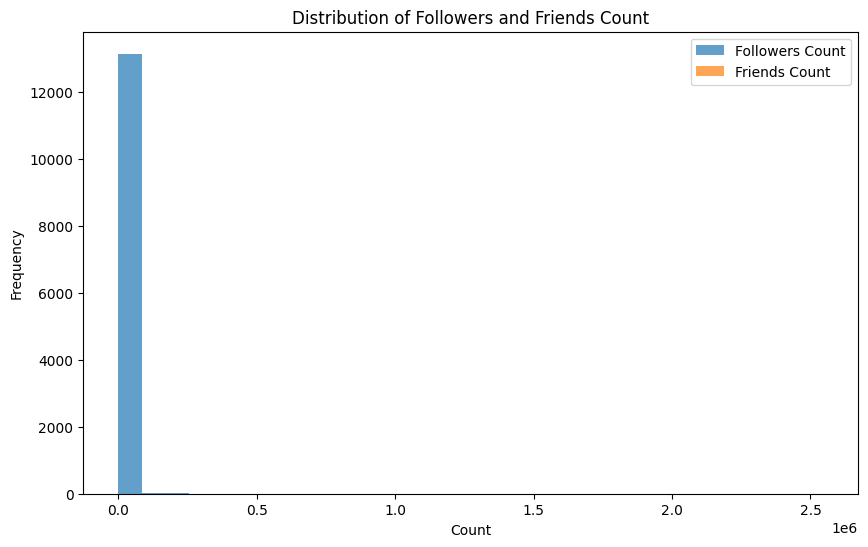

Content-Based Recommendations:
               id     screenName                   tags
19701  2827995949       _minnhhh  [ "#nationaldogday" ]
15763  2343039984   milesgelinas  [ "#nationaldogday" ]
15791   121933014    monicagtzRD  [ "#nationaldogday" ]
15787    26045851  AkemiChandler  [ "#nationaldogday" ]
15784   296513648       jdubya65  [ "#nationaldogday" ]
Collaborative Filtering Recommendations:
['#nationaldogday']


In [ ]:
def preprocess_data(data):
    data['processed_tags'] = data['tags'].str.replace("[", "").str.replace("]", "").str.replace("'", "")
    # strings back to lists
    data['tags_list'] = data['tags'].apply(eval)
    return data

def content_based_recommendation(data, user_id, top_n=5):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(data['processed_tags'])
    user_index = data[data['id'] == user_id].index[0]
    user_profile = tfidf_matrix[user_index]
    similarity_scores = cosine_similarity(user_profile, tfidf_matrix).flatten()
    similar_indices = np.argsort(similarity_scores)[::-1][:top_n]
    return data.iloc[similar_indices]

def create_user_item_matrix(data):
    users = data['id'].unique()
    # Get all unique items
    all_items = list(set(item for sublist in data['tags_list'] for item in sublist))
    user_item_matrix = pd.DataFrame(0, index=users, columns=all_items)
    for _, row in data.iterrows():
        for tag in row['tags_list']:
            user_item_matrix.at[row['id'], tag] = 1
    return user_item_matrix

def collaborative_filtering_recommendation(user_item_matrix, user_id, top_n=5):
    similarity_matrix = cosine_similarity(user_item_matrix)
    user_index = np.where(user_item_matrix.index == user_id)[0][0]
    user_similarity_scores = similarity_matrix[user_index]
    similar_users = np.argsort(user_similarity_scores)[::-1][1:top_n+1]
    recommendations = []
    for similar_user in similar_users:
        recommendations.extend(user_item_matrix.columns[user_item_matrix.iloc[similar_user] > 0].tolist())
    return list(set(recommendations))

def plot_data_distribution(data):
    plt.figure(figsize=(10, 6))
    plt.hist(data['followersCount'], bins=30, alpha=0.7, label='Followers Count')
    plt.hist(data['friendsCount'], bins=30, alpha=0.7, label='Friends Count')
    plt.legend()
    plt.title('Distribution of Followers and Friends Count')
    plt.xlabel('Count')
    plt.ylabel('Frequency')
    plt.show()

def main():
    data_preprocessed = preprocess_data(data)
    plot_data_distribution(data_preprocessed)
    # Select a user for recommendations
    user_id = data_preprocessed['id'].iloc[0]
    # Content-Based Recommendation
    print("Content-Based Recommendations:")
    content_recommendations = content_based_recommendation(data_preprocessed, user_id)
    print(content_recommendations[['id', 'screenName', 'tags']])
    # Collaborative Filtering Recommendation
    user_item_matrix = create_user_item_matrix(data_preprocessed)
    print("Collaborative Filtering Recommendations:")
    collaborative_recommendations = collaborative_filtering_recommendation(user_item_matrix, user_id)
    print(collaborative_recommendations)

main()


<ipython-input-7-33e34ffecc86>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tags_list'] = data['tags'].apply(eval)


Matrix Factorization Recommendations:
Index(['#nationaldogday', '#totliv', 'bieber', '#siriusblackisgay',
       'sofia richie'],
      dtype='object')


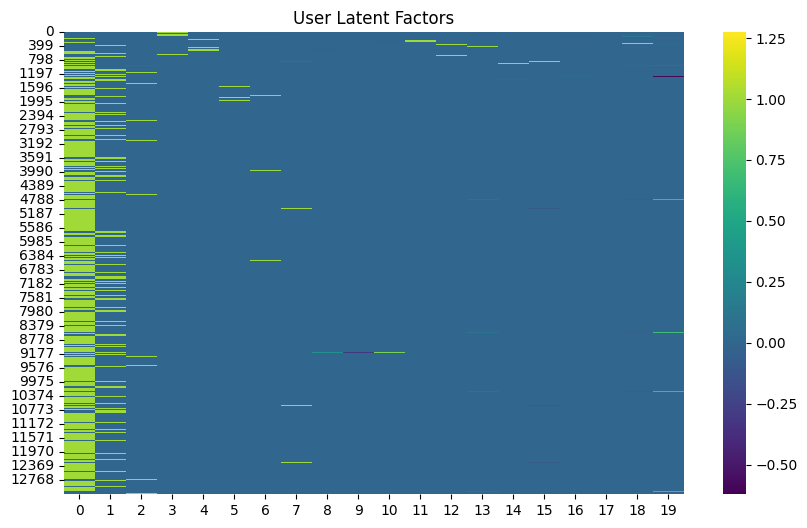

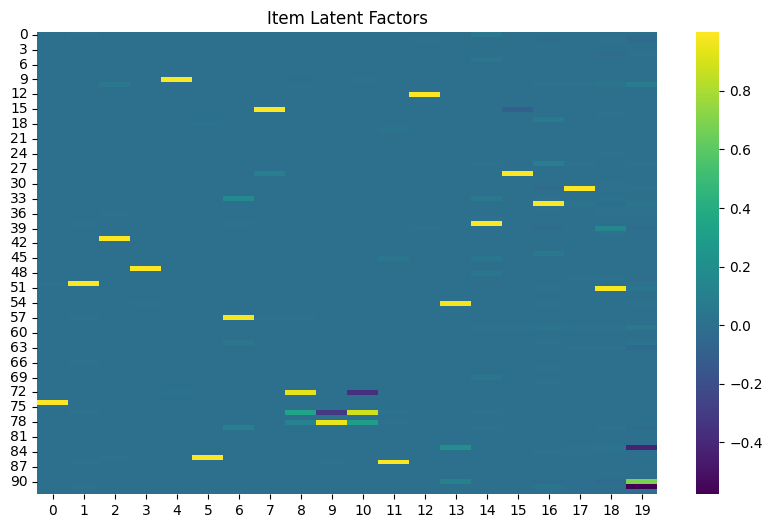

In [ ]:
def preprocess_data(data):
    data['tags_list'] = data['tags'].apply(eval)
    return data

def create_user_item_matrix(data):
    users = data['id'].unique()
    all_items = list(set(item for sublist in data['tags_list'] for item in sublist))
    user_item_matrix = pd.DataFrame(0, index=users, columns=all_items)
    for _, row in data.iterrows():
        for tag in row['tags_list']:
            user_item_matrix.at[row['id'], tag] = 1
    return user_item_matrix

# Matrix Factorization using SVD
def matrix_factorization_recommendation(user_item_matrix, user_id, top_n=5):
    svd = TruncatedSVD(n_components=50)
    user_factors = svd.fit_transform(user_item_matrix)
    item_factors = svd.components_.T
    reconstructed_matrix = np.dot(user_factors, item_factors.T)
    user_index = np.where(user_item_matrix.index == user_id)[0][0]
    user_recommendations = reconstructed_matrix[user_index]
    # the top N recommendations
    top_items = np.argsort(user_recommendations)[::-1][:top_n]
    recommended_items = user_item_matrix.columns[top_items]
    return recommended_items

def visualize_latent_factors(user_factors, item_factors):
    plt.figure(figsize=(10, 6))
    sns.heatmap(user_factors, cmap='viridis', annot=False, cbar=True)
    plt.title('User Latent Factors')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.heatmap(item_factors.T, cmap='viridis', annot=False, cbar=True)
    plt.title('Item Latent Factors')
    plt.show()

def main_matrix_factorization():
    data_preprocessed = preprocess_data(data)
    user_item_matrix = create_user_item_matrix(data_preprocessed)

    # SVD Recommendations
    user_id = data_preprocessed['id'].iloc[0]
    recommended_items = matrix_factorization_recommendation(user_item_matrix, user_id)
    print("Matrix Factorization Recommendations:")
    print(recommended_items)

    # Visualize Latent Factors
    svd = TruncatedSVD(n_components=20)
    user_factors = svd.fit_transform(user_item_matrix)
    item_factors = svd.components_
    visualize_latent_factors(user_factors, item_factors)

main_matrix_factorization()


<ipython-input-8-d78d6207f907>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['processed_tags'] = data['tags'].str.replace("[", "").str.replace("]", "").str.replace("'", "")


Content-Based Recommendations:
               id     screenName                   tags
19701  2827995949       _minnhhh  [ "#nationaldogday" ]
15763  2343039984   milesgelinas  [ "#nationaldogday" ]
15791   121933014    monicagtzRD  [ "#nationaldogday" ]
15787    26045851  AkemiChandler  [ "#nationaldogday" ]
15784   296513648       jdubya65  [ "#nationaldogday" ]
Evaluation Metrics:
{'Precision': 1.0, 'Recall': 1.0}


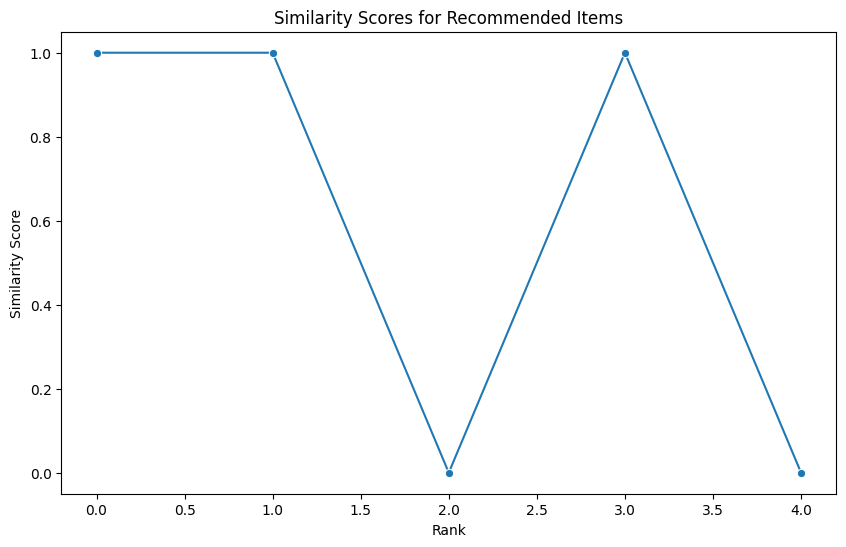

In [ ]:
def preprocess_for_content(data):
    data['processed_tags'] = data['tags'].str.replace("[", "").str.replace("]", "").str.replace("'", "")
    return data

def content_based_recommendation(data, user_id, top_n=5):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(data['processed_tags'])
    user_index = data[data['id'] == user_id].index[0]
    user_profile = tfidf_matrix[user_index]
    similarity_scores = cosine_similarity(user_profile, tfidf_matrix).flatten()
    similar_indices = np.argsort(similarity_scores)[::-1][:top_n]
    return data.iloc[similar_indices]

def evaluate_content_recommendations(data, recommendations, user_id):
    actual_items = set(data[data['id'] == user_id]['tags_list'].iloc[0])
    recommended_items = set(item for sublist in recommendations['tags_list'] for item in sublist)
    precision = len(actual_items & recommended_items) / len(recommended_items) if len(recommended_items) > 0 else 0
    recall = len(actual_items & recommended_items) / len(actual_items) if len(actual_items) > 0 else 0
    return {"Precision": precision, "Recall": recall}

def plot_similarity_scores(similarity_scores):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=similarity_scores, marker="o")
    plt.title("Similarity Scores for Recommended Items")
    plt.xlabel("Rank")
    plt.ylabel("Similarity Score")
    plt.show()

def main_content_based():
    data_preprocessed = preprocess_for_content(data)
    # Content-Based Recommendations
    user_id = data_preprocessed['id'].iloc[0]
    recommendations = content_based_recommendation(data_preprocessed, user_id)
    print("Content-Based Recommendations:")
    print(recommendations[['id', 'screenName', 'tags']])
    # Evaluate Recommendations
    evaluation = evaluate_content_recommendations(data_preprocessed, recommendations, user_id)
    print("Evaluation Metrics:")
    print(evaluation)
    # Scores
    user_index = data_preprocessed[data_preprocessed['id'] == user_id].index[0]
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(data_preprocessed['processed_tags'])
    user_profile = tfidf_matrix[user_index]
    similarity_scores = cosine_similarity(user_profile, tfidf_matrix).flatten()
    plot_similarity_scores(similarity_scores[:len(recommendations)])

main_content_based()


<ipython-input-10-455364395938>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tags_list'] = data['tags'].apply(eval)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


User-Based KNN Recommendations:
['#nationaldogday']
KNN Evaluation Metrics:
{'Precision': 1.0, 'Recall': 1.0}


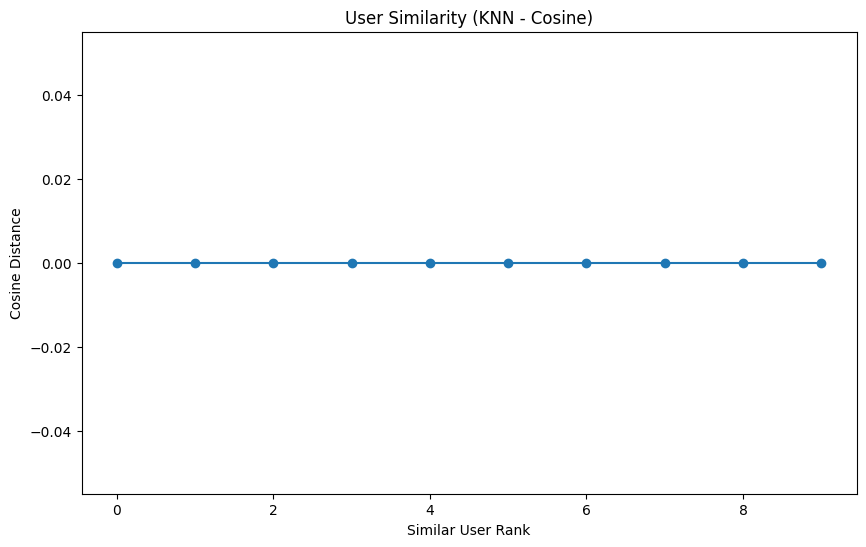

Item-Based Jaccard Recommendations:
['#1yearofjetblackheart', '#weekend', '#feartwd', '#italyearthquake', '#idonottrustanyonewho']
Jaccard Evaluation Metrics:
{'Precision': 0.0, 'Recall': 0.0}


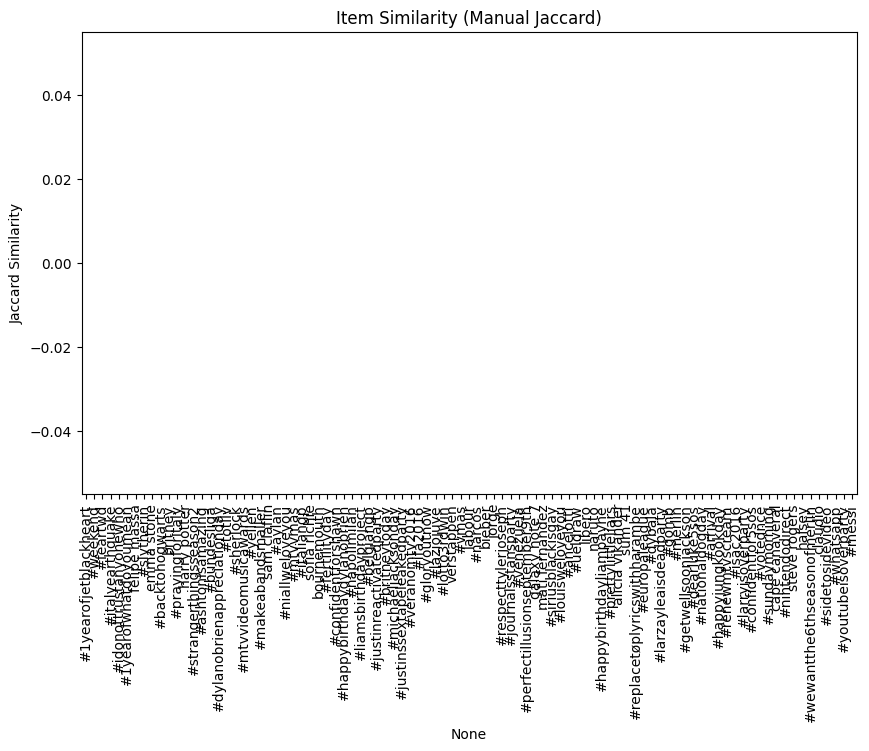

In [ ]:
def preprocess_data(data):
    data['tags_list'] = data['tags'].apply(eval)
    return data

def create_user_item_matrix(data):
    users = data['id'].unique()
    all_items = list(set(item for sublist in data['tags_list'] for item in sublist))
    user_item_matrix = pd.DataFrame(0, index=users, columns=all_items)
    for _, row in data.iterrows():
        for tag in row['tags_list']:
            user_item_matrix.at[row['id'], tag] = 1
    return user_item_matrix

def user_based_knn_recommendation(user_item_matrix, user_id, top_n=5):
    knn = NearestNeighbors(metric='cosine', algorithm='brute')
    knn.fit(user_item_matrix)
    user_index = np.where(user_item_matrix.index == user_id)[0][0]
    distances, indices = knn.kneighbors(user_item_matrix.iloc[user_index].values.reshape(1, -1), n_neighbors=top_n+1)
    similar_users = indices.flatten()[1:]
    recommendations = []
    for neighbor in similar_users:
        recommendations.extend(user_item_matrix.columns[user_item_matrix.iloc[neighbor] > 0].tolist())
    return list(set(recommendations))

def item_based_jaccard_recommendation_fixed_v2(user_item_matrix, user_id, top_n=5):
    user_data = user_item_matrix.loc[user_id]
    item_similarities = []
    for item in user_item_matrix.columns:
        intersection = np.sum((user_data > 0) & (user_item_matrix[item] > 0))
        union = np.sum((user_data > 0) | (user_item_matrix[item] > 0))
        similarity = intersection / union if union != 0 else 0
        item_similarities.append((item, similarity))
    sorted_items = sorted(item_similarities, key=lambda x: x[1], reverse=True)[:top_n]
    recommendations = [item[0] for item in sorted_items]
    return recommendations

def evaluate_collaborative_recommendations(user_item_matrix, user_id, recommendations):
    actual_items = set(user_item_matrix.columns[user_item_matrix.loc[user_id] > 0])
    recommended_items = set(recommendations)
    precision = len(actual_items & recommended_items) / len(recommended_items) if len(recommended_items) > 0 else 0
    recall = len(actual_items & recommended_items) / len(actual_items) if len(actual_items) > 0 else 0
    return {"Precision": precision, "Recall": recall}

def plot_user_similarity(user_item_matrix, user_id):
    knn = NearestNeighbors(metric='cosine', algorithm='brute')
    knn.fit(user_item_matrix)
    user_index = np.where(user_item_matrix.index == user_id)[0][0]
    distances, _ = knn.kneighbors(user_item_matrix.iloc[user_index].values.reshape(1, -1), n_neighbors=10)
    plt.figure(figsize=(10, 6))
    plt.plot(distances.flatten(), marker='o')
    plt.title("User Similarity (KNN - Cosine)")
    plt.xlabel("Similar User Rank")
    plt.ylabel("Cosine Distance")
    plt.show()

def plot_item_similarity_fixed(user_item_matrix, user_id):
    user_data = user_item_matrix.loc[user_id]
    similarities = []
    for item in user_item_matrix.columns:
        intersection = np.sum((user_data > 0) & (user_item_matrix[item] > 0))
        union = np.sum((user_data > 0) | (user_item_matrix[item] > 0))
        similarity = intersection / union if union != 0 else 0
        similarities.append(similarity)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=user_item_matrix.columns, y=similarities)
    plt.xticks(rotation=90)
    plt.title("Item Similarity (Manual Jaccard)")
    plt.ylabel("Jaccard Similarity")
    plt.show()

def main_collaborative_filtering_corrected():
    data_preprocessed = preprocess_data(data)
    user_item_matrix = create_user_item_matrix(data_preprocessed)
    # User-Based KNN Recommendations
    user_id = data_preprocessed['id'].iloc[0]
    knn_recommendations = user_based_knn_recommendation(user_item_matrix, user_id)
    print("User-Based KNN Recommendations:")
    print(knn_recommendations)
    knn_evaluation = evaluate_collaborative_recommendations(user_item_matrix, user_id, knn_recommendations)
    print("KNN Evaluation Metrics:")
    print(knn_evaluation)
    plot_user_similarity(user_item_matrix, user_id)
    # Item-Based Jaccard Recommendations
    jaccard_recommendations = item_based_jaccard_recommendation_fixed_v2(user_item_matrix, user_id)
    print("Item-Based Jaccard Recommendations:")
    print(jaccard_recommendations)
    jaccard_evaluation = evaluate_collaborative_recommendations(user_item_matrix, user_id, jaccard_recommendations)
    print("Jaccard Evaluation Metrics:")
    print(jaccard_evaluation)
    plot_item_similarity_fixed(user_item_matrix, user_id)

main_collaborative_filtering_corrected()


<ipython-input-12-9d141236af99>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tags_list'] = data['tags'].apply(eval)


SVD-Based Recommendations:
Index(['#nationaldogday', '#totliv', 'jorge', 'cape canaveral',
       '#sundaymorning'],
      dtype='object')
SVD Evaluation Metrics:
{'RMSE': 7.865934140200654e-05}


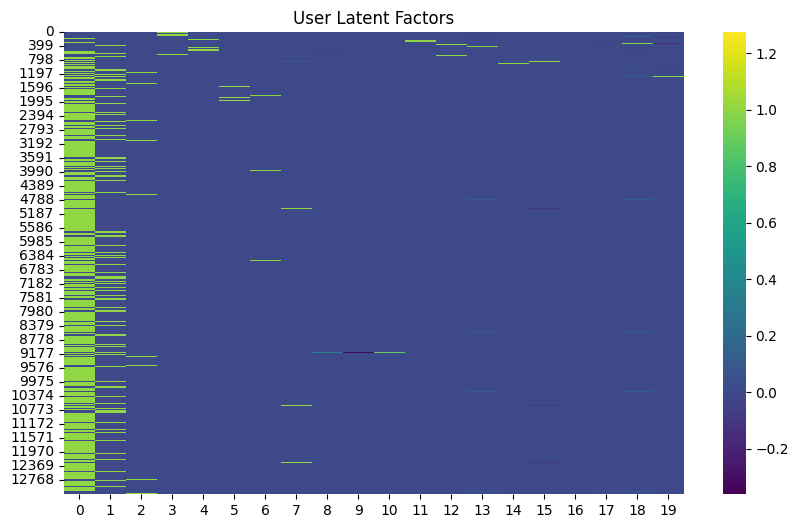

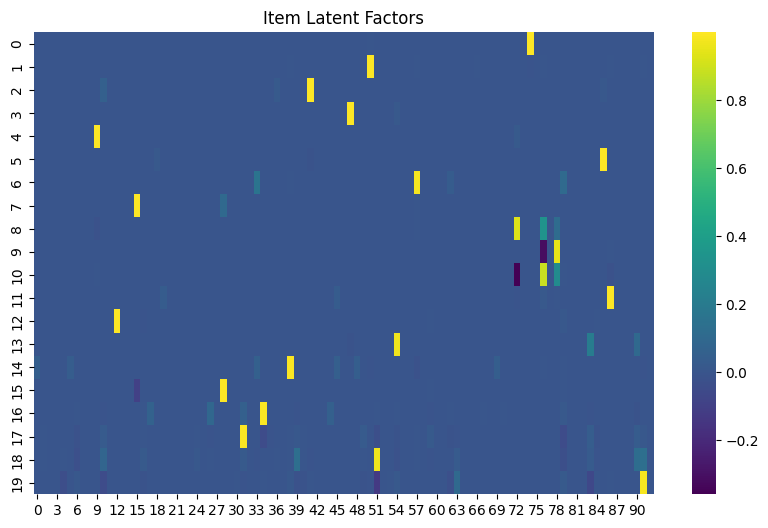

In [ ]:
# MEME METHODE UEN AUTRE FACON D AFFICHER LE GRAPH
def preprocess_data(data):
    data['tags_list'] = data['tags'].apply(eval)
    return data

def create_user_item_matrix(data):
    users = data['id'].unique()
    all_items = list(set(item for sublist in data['tags_list'] for item in sublist))
    user_item_matrix = pd.DataFrame(0, index=users, columns=all_items)
    for _, row in data.iterrows():
        for tag in row['tags_list']:
            user_item_matrix.at[row['id'], tag] = 1
    return user_item_matrix

def matrix_factorization_svd(user_item_matrix, n_components=20):
    svd = TruncatedSVD(n_components=n_components)
    user_factors = svd.fit_transform(user_item_matrix)
    item_factors = svd.components_.T
    reconstructed_matrix = np.dot(user_factors, item_factors.T)
    return user_factors, item_factors, reconstructed_matrix, svd

def recommend_with_svd(reconstructed_matrix, user_item_matrix, user_id, top_n=5):
    user_index = np.where(user_item_matrix.index == user_id)[0][0]
    user_recommendations = reconstructed_matrix[user_index]
    top_items = np.argsort(user_recommendations)[::-1][:top_n]
    recommended_items = user_item_matrix.columns[top_items]
    return recommended_items

def evaluate_svd_recommendations(user_item_matrix, reconstructed_matrix, user_id):
    user_index = np.where(user_item_matrix.index == user_id)[0][0]
    actual_ratings = user_item_matrix.iloc[user_index].values
    predicted_ratings = reconstructed_matrix[user_index]
    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    return {"RMSE": rmse}

def plot_latent_factors(user_factors, item_factors):
    plt.figure(figsize=(10, 6))
    sns.heatmap(user_factors, cmap='viridis', annot=False, cbar=True)
    plt.title('User Latent Factors')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.heatmap(item_factors.T, cmap='viridis', annot=False, cbar=True)
    plt.title('Item Latent Factors')
    plt.show()

def main_matrix_factorization():
    data_preprocessed = preprocess_data(data)
    user_item_matrix = create_user_item_matrix(data_preprocessed)

    user_factors, item_factors, reconstructed_matrix, svd_model = matrix_factorization_svd(user_item_matrix, n_components=20)

    user_id = data_preprocessed['id'].iloc[0]
    recommendations = recommend_with_svd(reconstructed_matrix, user_item_matrix, user_id)
    print("SVD-Based Recommendations:")
    print(recommendations)

    evaluation = evaluate_svd_recommendations(user_item_matrix, reconstructed_matrix, user_id)
    print("SVD Evaluation Metrics:")
    print(evaluation)

    plot_latent_factors(user_factors, item_factors)


main_matrix_factorization()


<ipython-input-12-9d141236af99>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tags_list'] = data['tags'].apply(eval)


RMSE: 0.0001
Precision@5: 0.2000
AUC: 1.0000


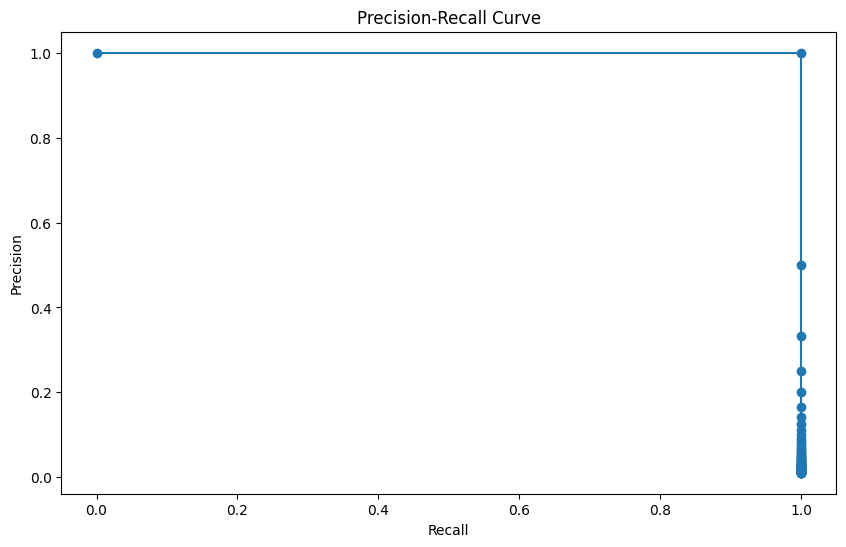

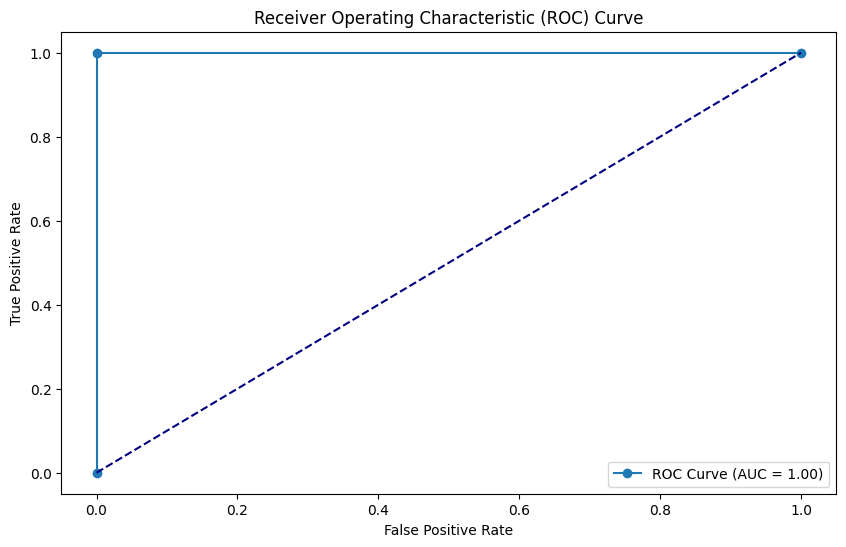

In [ ]:
def calculate_rmse(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f"RMSE: {rmse:.4f}")
    return rmse

def calculate_precision_at_k(recommended_items, actual_items, k=5):
    top_k_recommendations = recommended_items[:k]
    relevant_items = set(top_k_recommendations).intersection(set(actual_items))
    precision_at_k = len(relevant_items) / k
    print(f"Precision@{k}: {precision_at_k:.4f}")
    return precision_at_k

def calculate_auc(actual, predicted):
    auc_score = roc_auc_score(actual, predicted)
    print(f"AUC: {auc_score:.4f}")
    return auc_score

def plot_precision_recall_curve(actual, predicted):
    precision, recall, _ = precision_recall_curve(actual, predicted)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, marker='o')
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

def plot_roc_curve(actual, predicted):
    fpr, tpr, _ = roc_curve(actual, predicted)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", marker='o')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

def main_evaluation():
    data_preprocessed = preprocess_data(data)
    user_item_matrix = create_user_item_matrix(data_preprocessed)

    user_factors, item_factors, reconstructed_matrix, svd_model = matrix_factorization_svd(user_item_matrix, n_components=20)

    user_id = data_preprocessed['id'].iloc[0]
    user_index = np.where(user_item_matrix.index == user_id)[0][0]
    actual = user_item_matrix.iloc[user_index].values
    predicted = reconstructed_matrix[user_index]
    calculate_rmse(actual, predicted)
    recommended_items = recommend_with_svd(reconstructed_matrix, user_item_matrix, user_id, top_n=10)
    actual_items = user_item_matrix.columns[actual > 0]
    calculate_precision_at_k(recommended_items, actual_items, k=5)
    calculate_auc(actual, predicted)
    plot_precision_recall_curve(actual, predicted)
    plot_roc_curve(actual, predicted)

main_evaluation()


<ipython-input-16-ac0a203cfdbe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tags_list'] = data['tags'].apply(eval)



Handling Cold-Start Users:
Cold-Start Recommendations: ['#nationaldogday', '#respecttylerjoseph', '#gloryoutnow', '#narcos', '#backtohogwarts']

Performing Co-Clustering:
User Clusters: [0 1 2 3 4]
Item Clusters: [0 1 2 3 4]


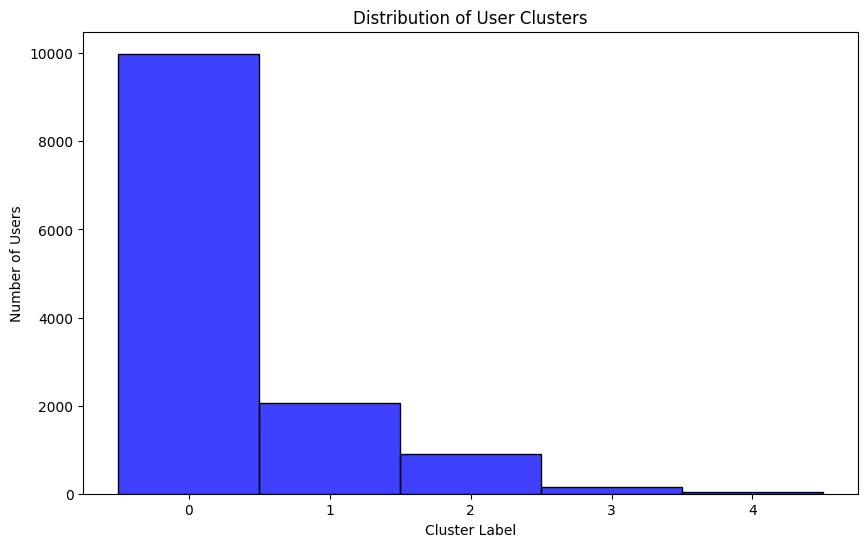

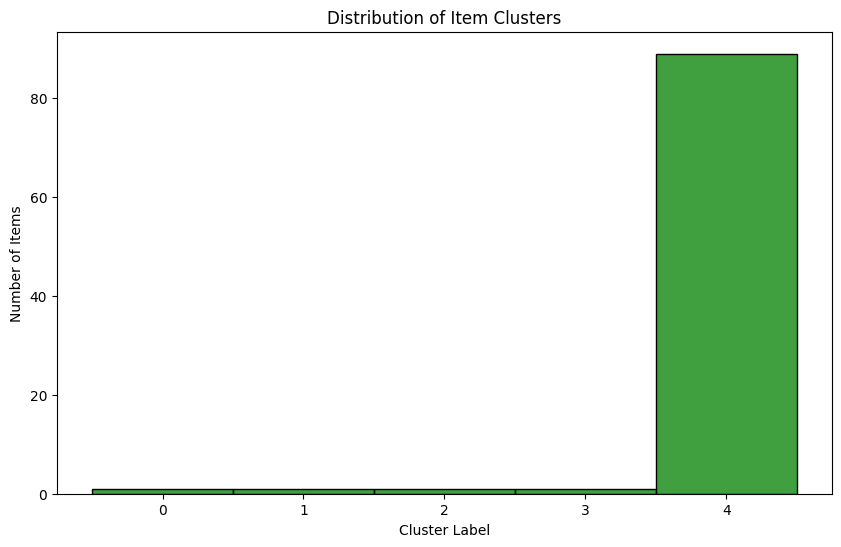


Generating Hybrid Recommendations:
Cold-Start Recommendations: ['#nationaldogday', '#respecttylerjoseph', '#gloryoutnow', '#narcos', '#backtohogwarts']
Hybrid Recommendations: ['#backtohogwarts', '#narcos', '#totliv', '#nationaldogday', 'jorge', '#respecttylerjoseph', '#gloryoutnow', '#strangerthingsseason2', '#sundaymorning']


In [ ]:
def preprocess_data(data):
    data['tags_list'] = data['tags'].apply(eval)
    return data

def create_user_item_matrix(data):
    users = data['id'].unique()
    all_items = list(set(item for sublist in data['tags_list'] for item in sublist))
    user_item_matrix = pd.DataFrame(0, index=users, columns=all_items)
    for _, row in data.iterrows():
        for tag in row['tags_list']:
            user_item_matrix.at[row['id'], tag] = 1
    return user_item_matrix

def handle_cold_start(user_item_matrix, top_n=5):
    item_popularity = user_item_matrix.sum(axis=0)
    popular_items = np.argsort(item_popularity)[::-1][:top_n]
    recommendations = user_item_matrix.columns[popular_items]
    print(f"Cold-Start Recommendations: {list(recommendations)}")
    return recommendations

def co_clustering(user_item_matrix, n_clusters=5):
    coo = coo_matrix(user_item_matrix.values)  # Convert to sparse matrix for efficiency
    kmeans_users = KMeans(n_clusters=n_clusters, random_state=42).fit(coo.toarray())
    kmeans_items = KMeans(n_clusters=n_clusters, random_state=42).fit(coo.T.toarray())

    user_clusters = kmeans_users.labels_
    item_clusters = kmeans_items.labels_

    print(f"User Clusters: {np.unique(user_clusters)}")
    print(f"Item Clusters: {np.unique(item_clusters)}")
    return user_clusters, item_clusters

def visualize_co_clustering(user_clusters, item_clusters):
    plt.figure(figsize=(10, 6))
    sns.histplot(user_clusters, kde=False, bins=np.arange(max(user_clusters) + 2) - 0.5, color="blue")
    plt.title("Distribution of User Clusters")
    plt.xlabel("Cluster Label")
    plt.ylabel("Number of Users")
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(item_clusters, kde=False, bins=np.arange(max(item_clusters) + 2) - 0.5, color="green")
    plt.title("Distribution of Item Clusters")
    plt.xlabel("Cluster Label")
    plt.ylabel("Number of Items")
    plt.show()

def matrix_factorization_svd(user_item_matrix, n_components=20):
    svd = TruncatedSVD(n_components=n_components)
    user_factors = svd.fit_transform(user_item_matrix)
    item_factors = svd.components_.T
    reconstructed_matrix = np.dot(user_factors, item_factors.T)
    return reconstructed_matrix, user_factors, item_factors, svd

def recommend_with_svd(reconstructed_matrix, user_item_matrix, user_id, top_n=5):
    user_index = np.where(user_item_matrix.index == user_id)[0][0]
    user_recommendations = reconstructed_matrix[user_index]
    top_items = np.argsort(user_recommendations)[::-1][:top_n]
    recommended_items = user_item_matrix.columns[top_items]
    return recommended_items

def hybrid_recommendations(user_item_matrix, user_id, top_n=5):
    reconstructed_matrix, _, _, _ = matrix_factorization_svd(user_item_matrix)
    collaborative_recommendations = recommend_with_svd(reconstructed_matrix, user_item_matrix, user_id, top_n)
    cold_start_recommendations = handle_cold_start(user_item_matrix, top_n)
    hybrid_recommendations = list(set(collaborative_recommendations) | set(cold_start_recommendations))
    print(f"Hybrid Recommendations: {hybrid_recommendations}")
    return hybrid_recommendations

def main_advanced_applications():
    data_preprocessed = preprocess_data(data)
    user_item_matrix = create_user_item_matrix(data_preprocessed)
    print("\nHandling Cold-Start Users:")
    handle_cold_start(user_item_matrix, top_n=5)
    print("\nPerforming Co-Clustering:")
    user_clusters, item_clusters = co_clustering(user_item_matrix, n_clusters=5)
    visualize_co_clustering(user_clusters, item_clusters)
    print("\nGenerating Hybrid Recommendations:")
    user_id = data_preprocessed['id'].iloc[0]
    hybrid_recommendations(user_item_matrix, user_id, top_n=5)

main_advanced_applications()
